# Analyze *falcon* clusters

This notebook can be used to analyze clusters generated by *falcon*. For the moment, it can:
* Show stats about the clusters: the number of clusters, the average size...
* Plot

In [29]:
import os
import pandas
import matplotlib.pyplot as plt
import numpy as np
import re
import spectrum_utils.plot as sup

from ms_io import ms_io

### Open the file and show basic stats

In [30]:
file = os.path.join('/media/maesk/WD/falcon',
                    'CCLE_Protein_01',
                    'nn',
                    'eps_0.1_minsample_2',
                    'fragm_tol_0.5_hash_len_800',
                    'prec_tol_20',
                    'clusters.csv')
dir_pkl = "/media/maesk/WD/falcon/CCLE_Protein_01/spectra"

df = pandas.read_csv(file)
clustMask = df['cluster'] != -1
clustDf = df[clustMask]
nClusteredSp = len(clustDf)
propClusteredSp = nClusteredSp/len(df)
nClusters = np.max(clustDf['cluster']) + 1

print("Number of (non filtered) input spectra: {}".format(len(df)))
print("Number of clustered spectra: {0} ({1:.2f}%)".format(nClusteredSp, propClusteredSp*100))
print("Number of clusters: {}".format(nClusters))
print("Spectra per cluster: {}".format(nClusteredSp/nClusters))

Number of (non filtered) input spectra: 457075
Number of clustered spectra: 50970 (11.15%)
Number of clusters: 19077
Spectra per cluster: 2.6718037427268437


### Plot the n first clusters

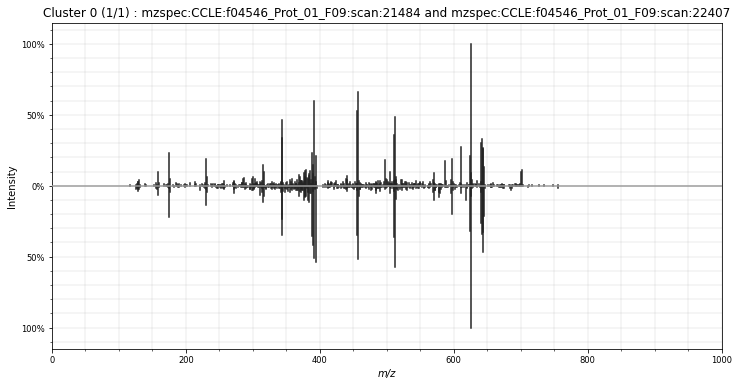

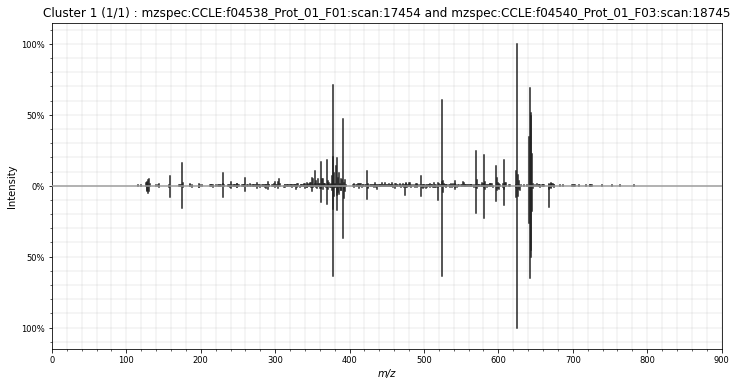

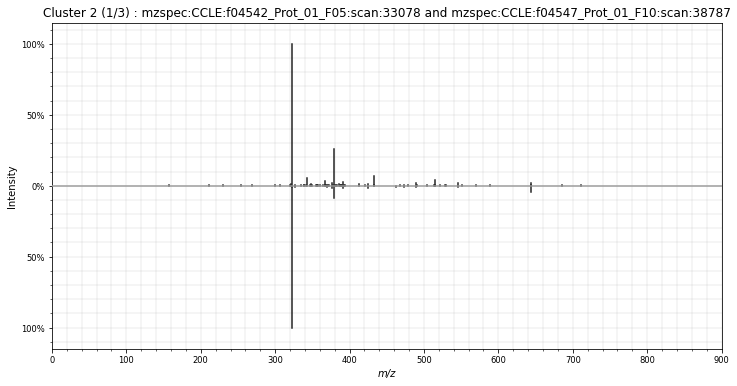

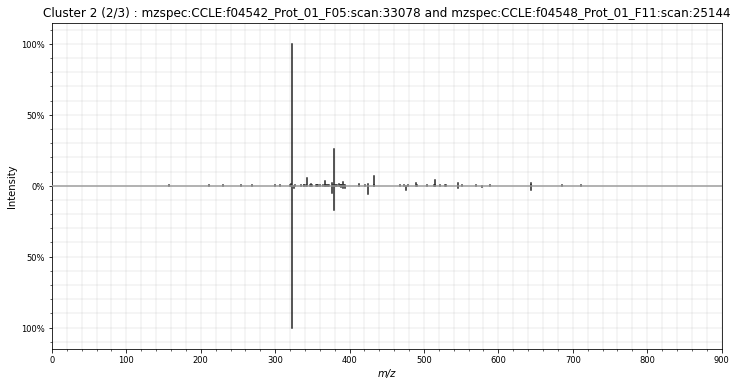

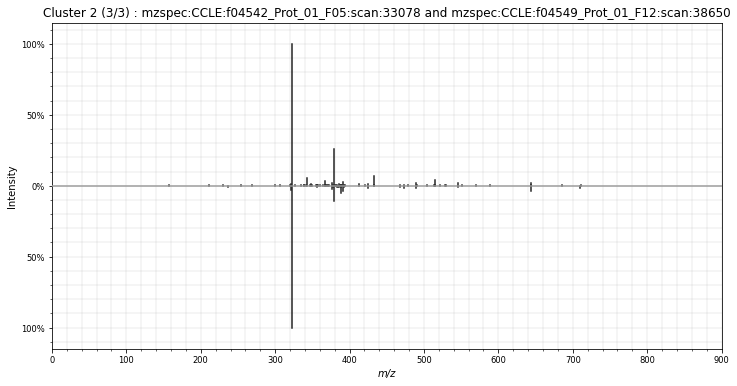

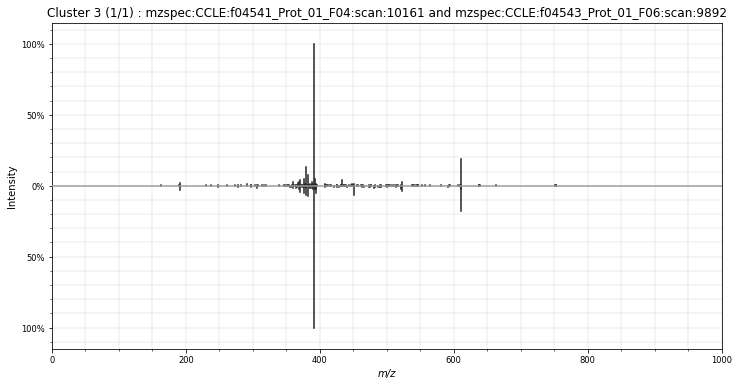

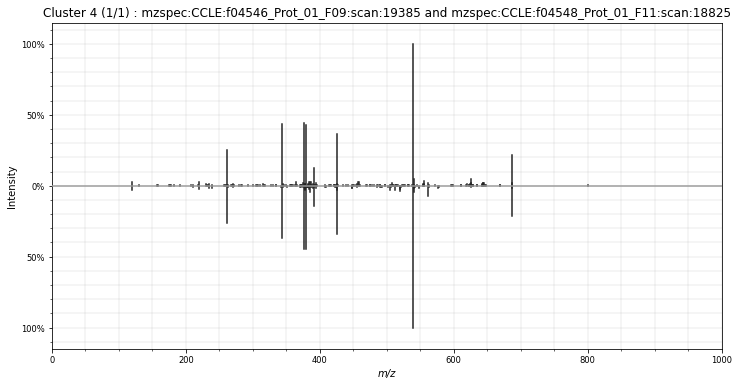

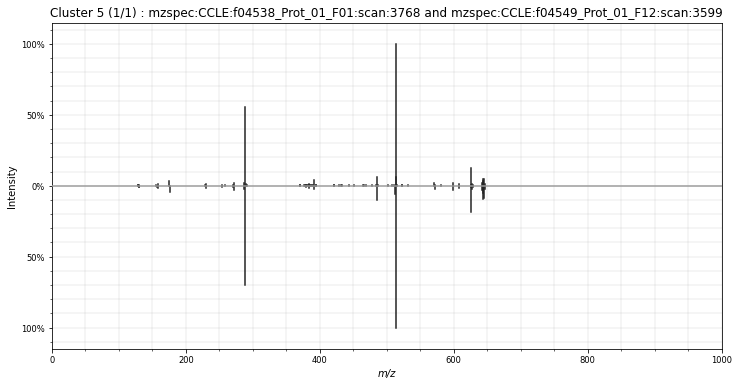

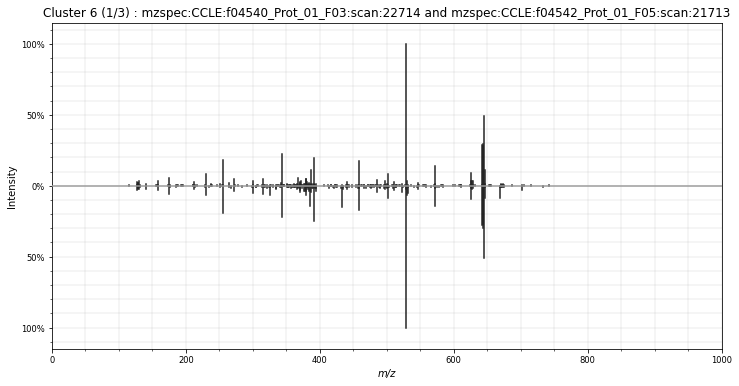

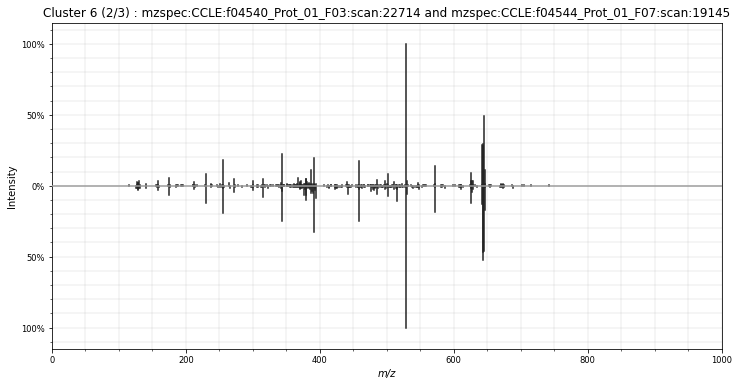

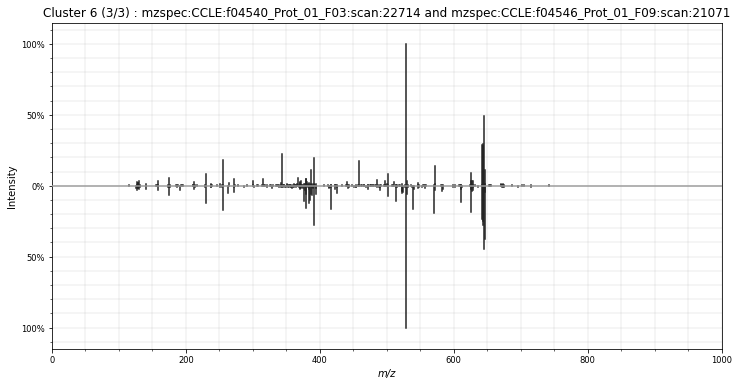

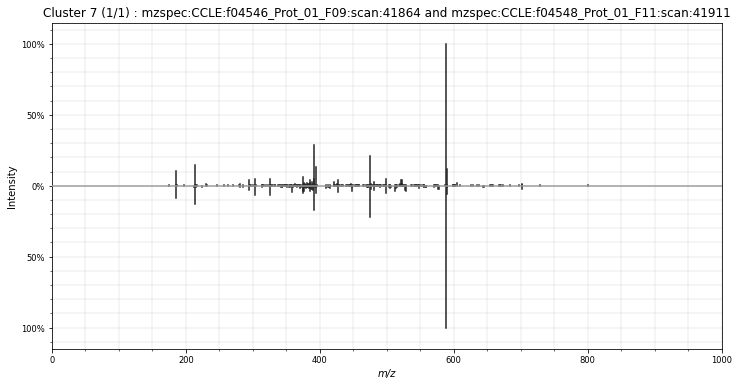

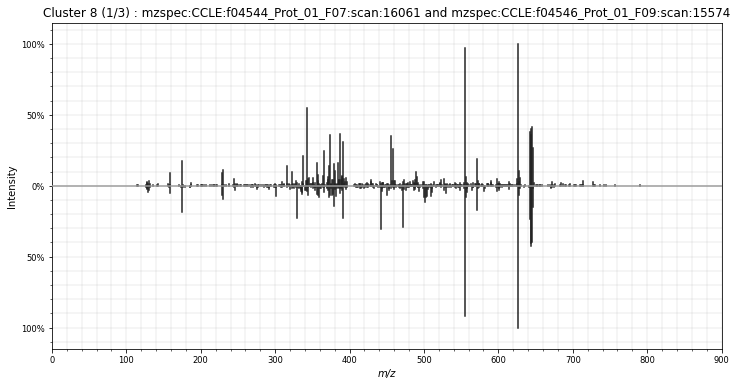

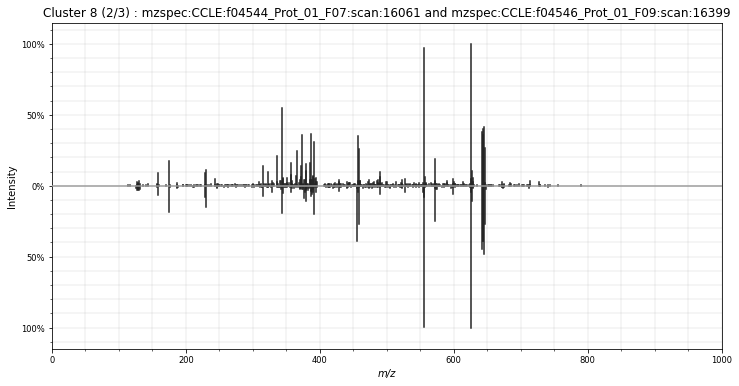

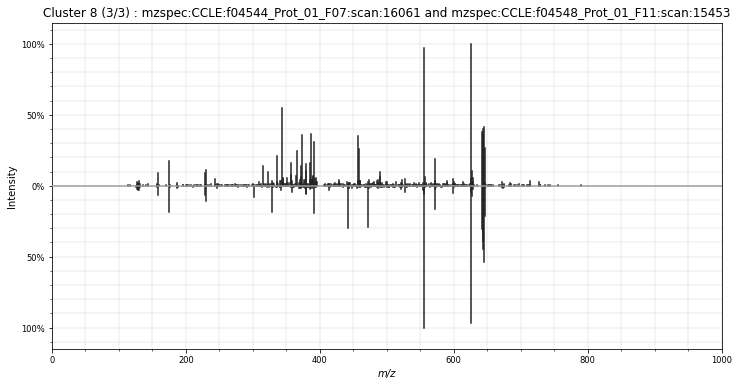

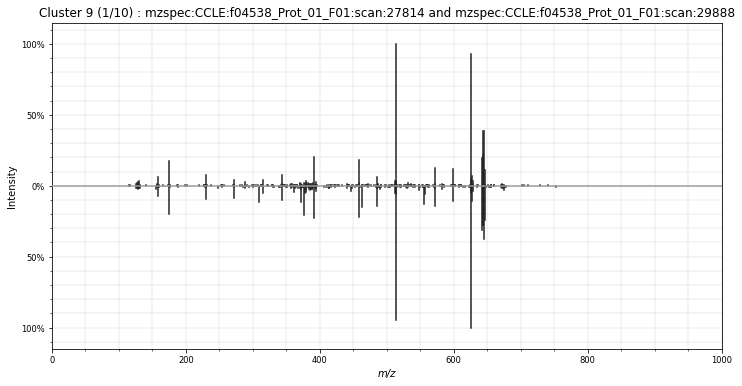

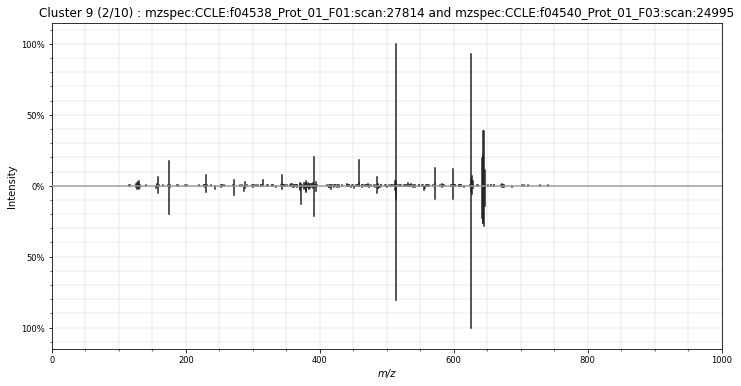

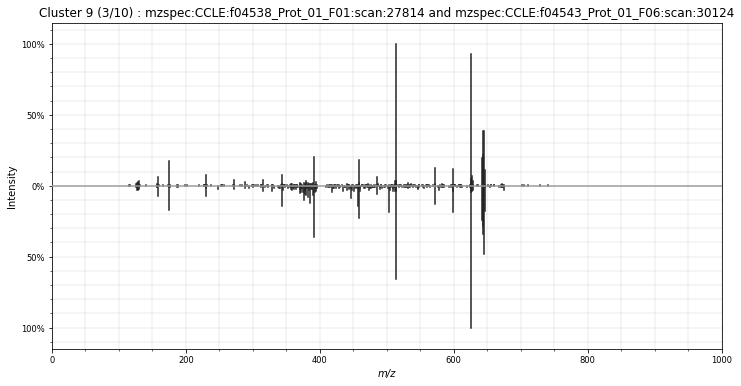

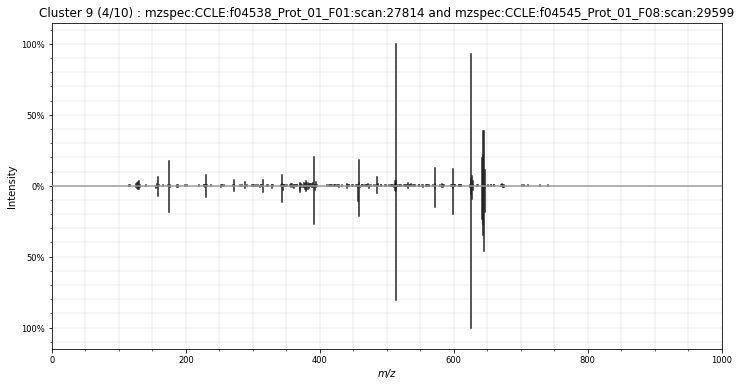

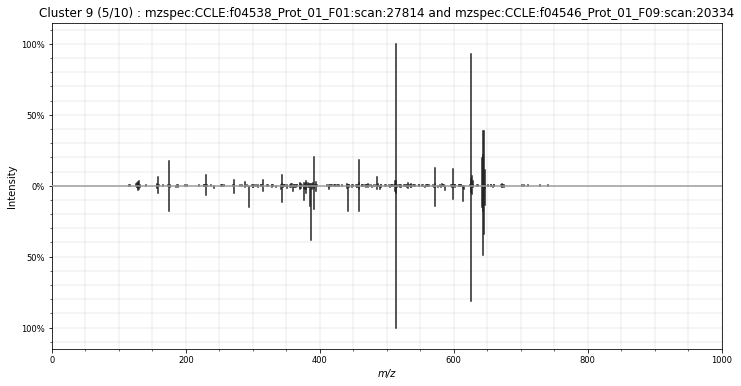

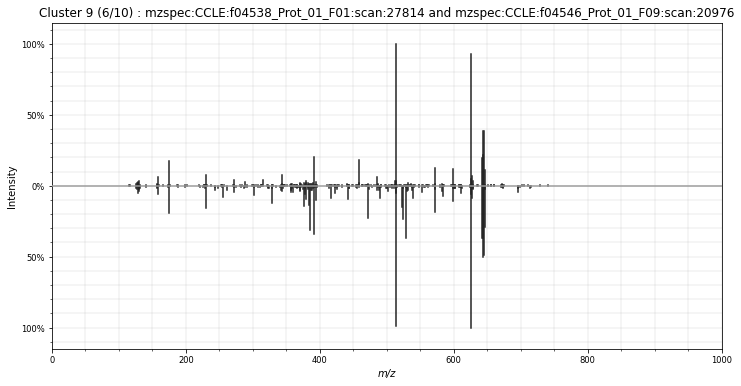

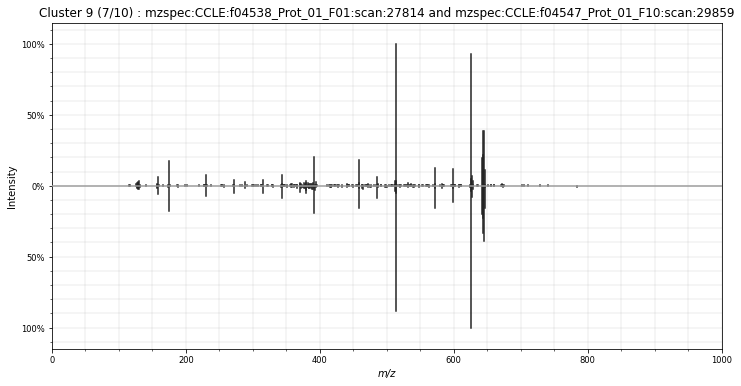

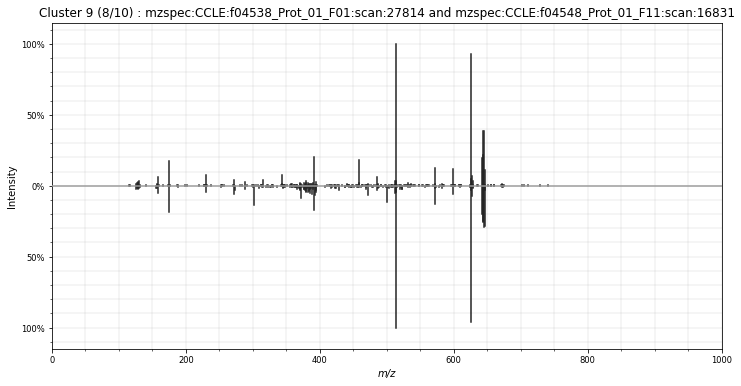

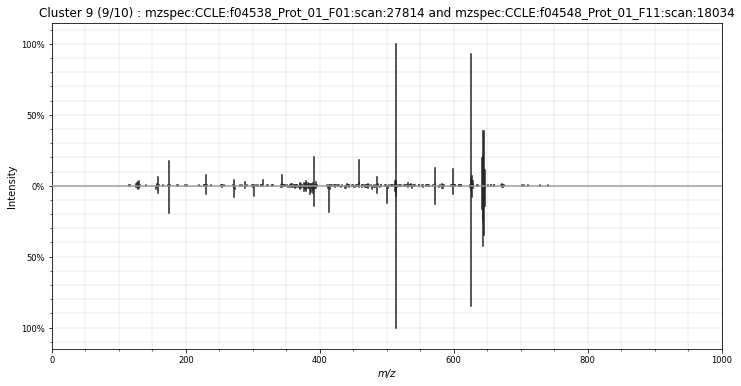

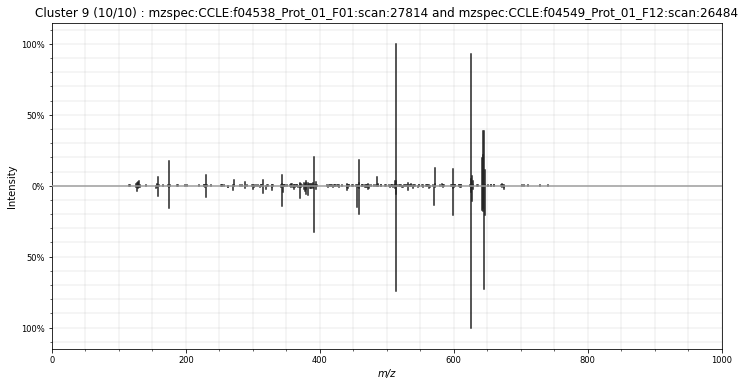

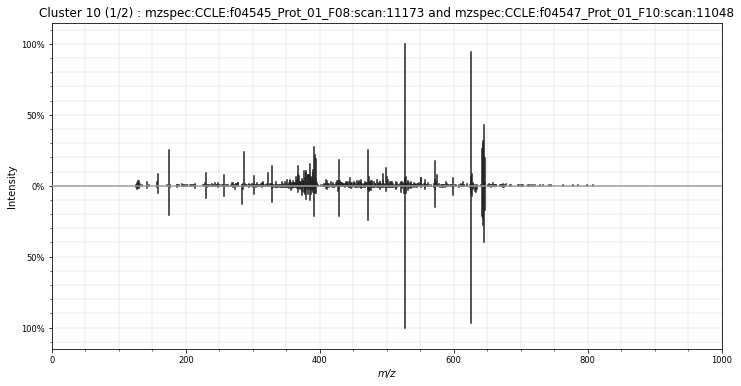

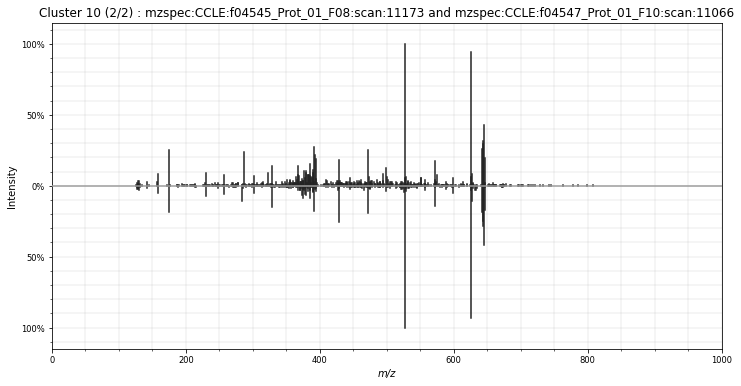

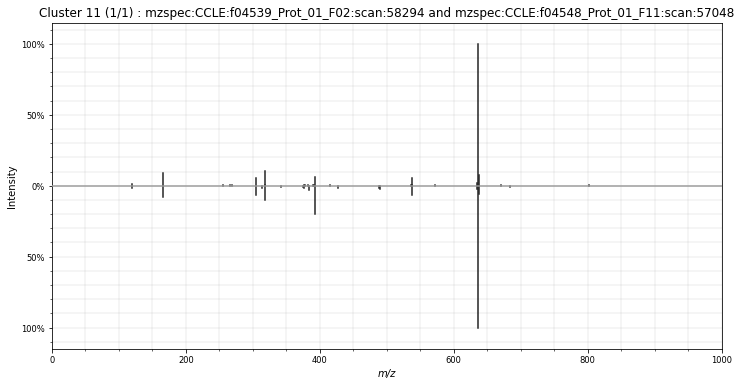

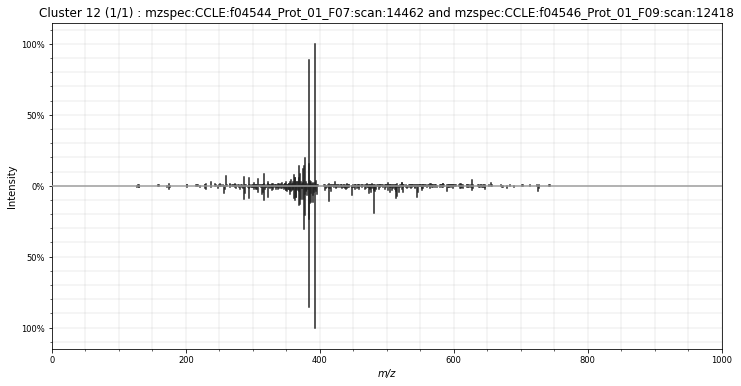

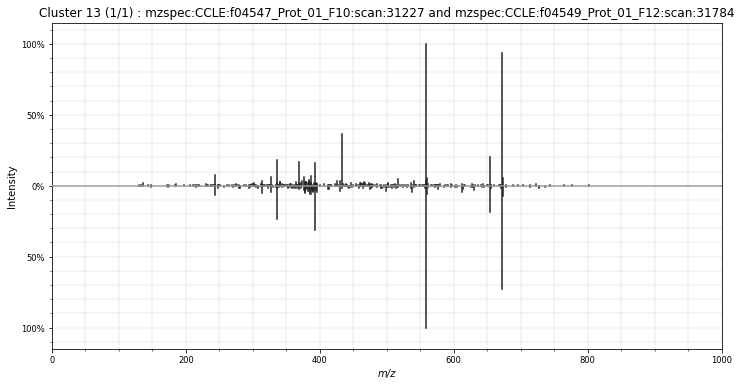

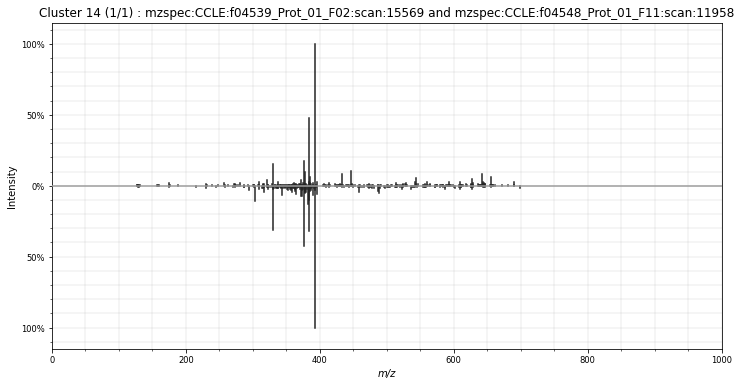

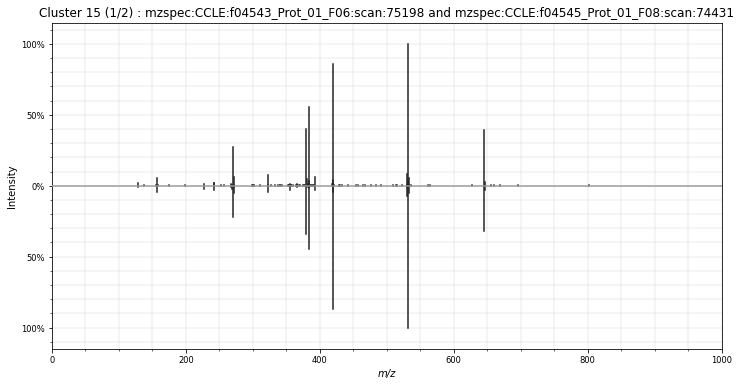

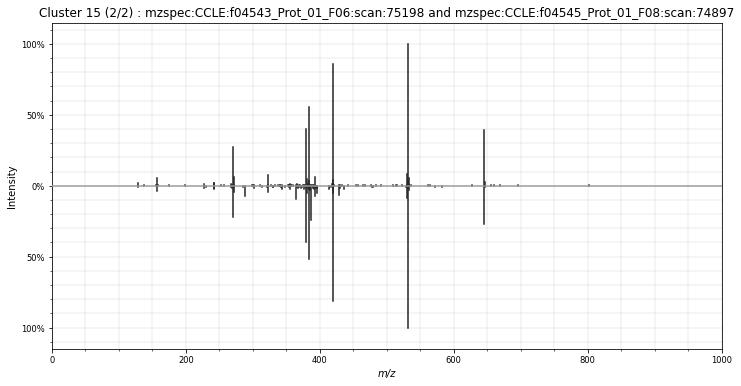

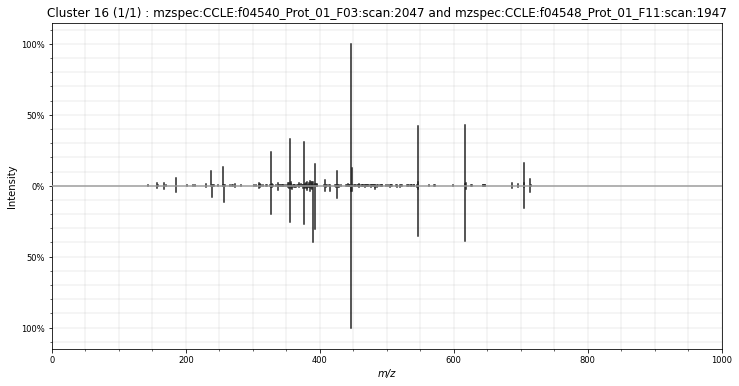

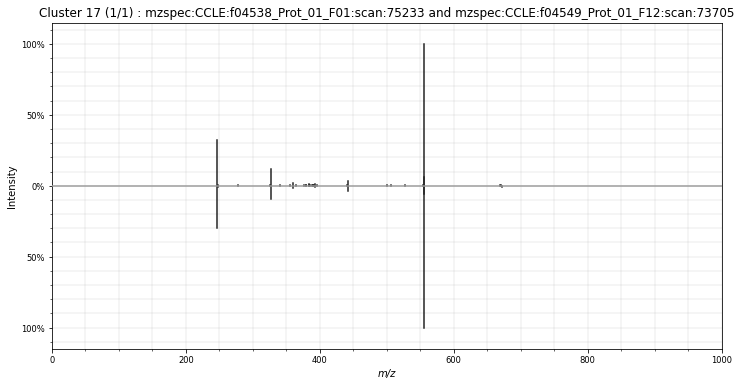

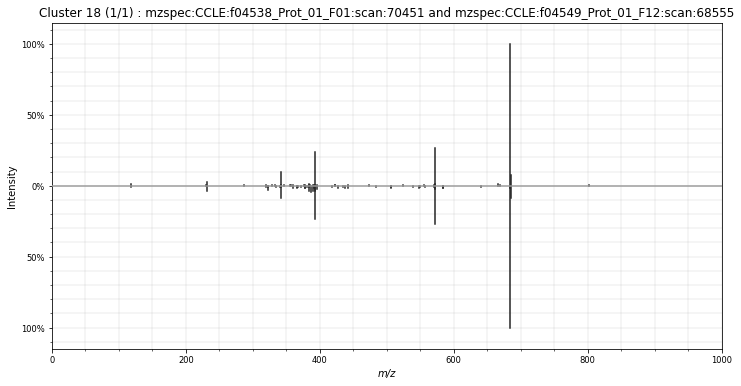

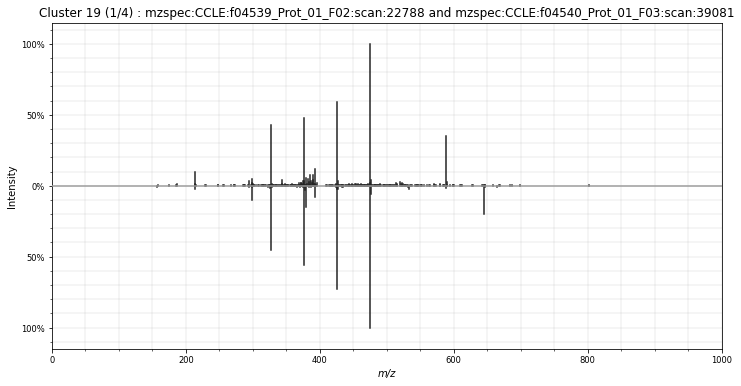

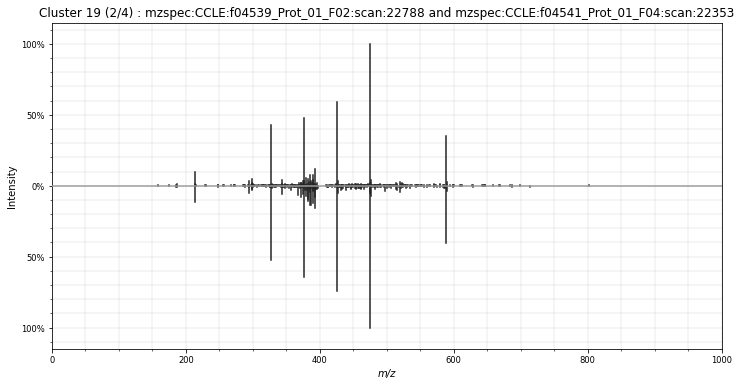

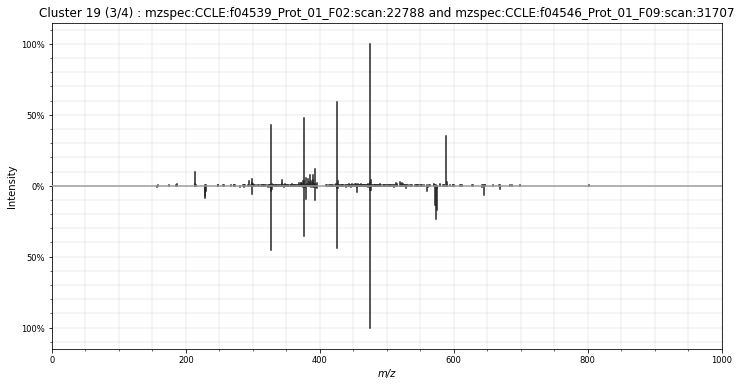

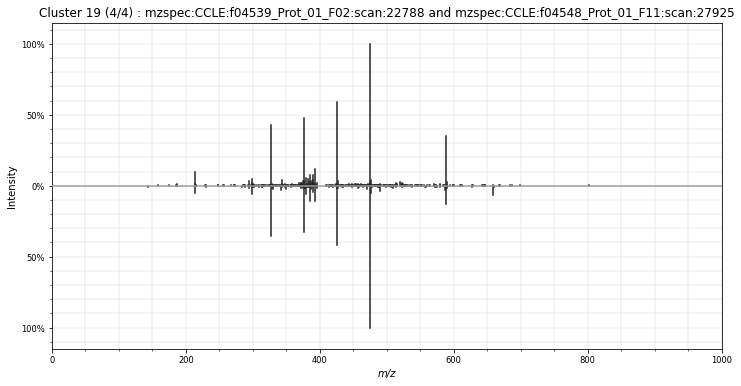

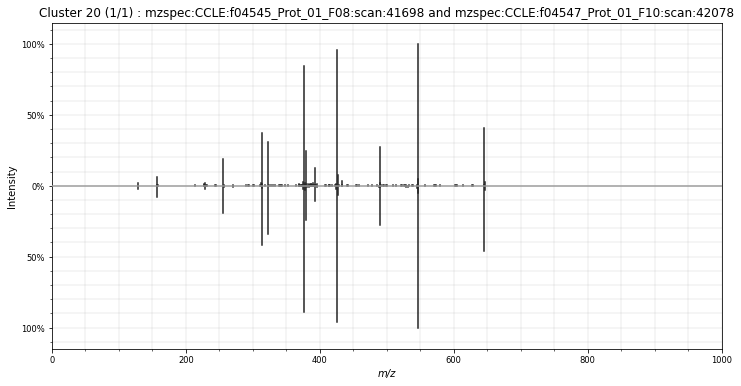

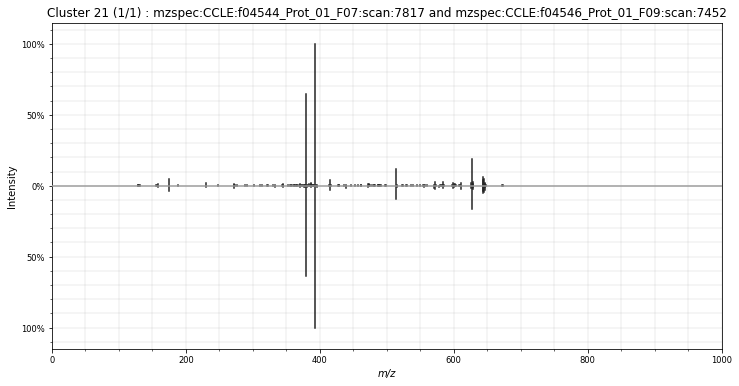

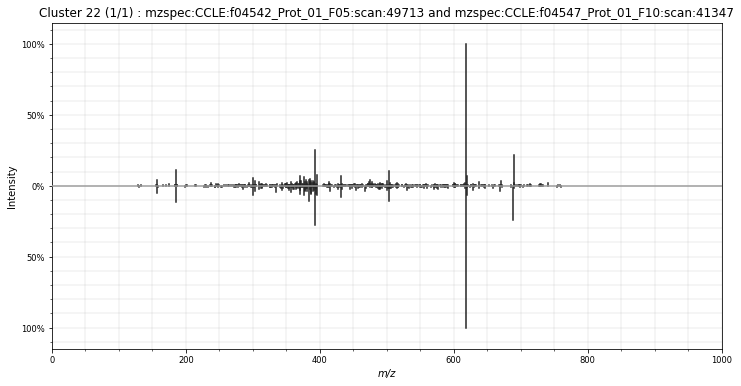

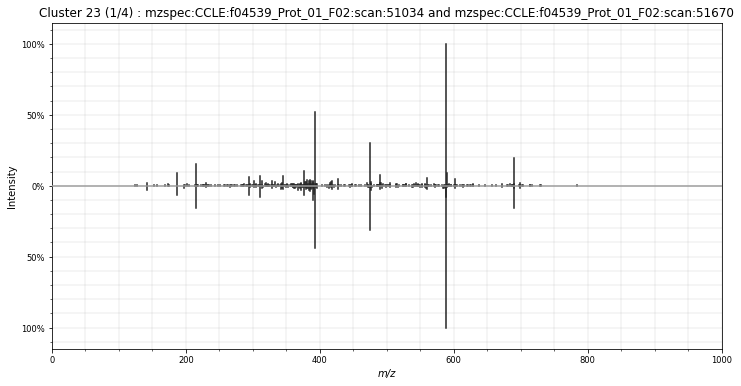

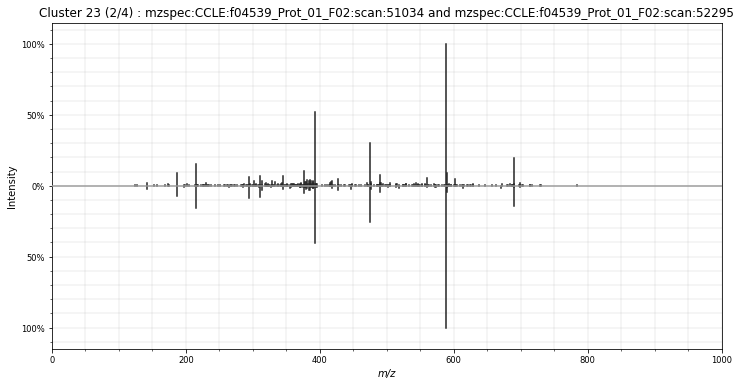

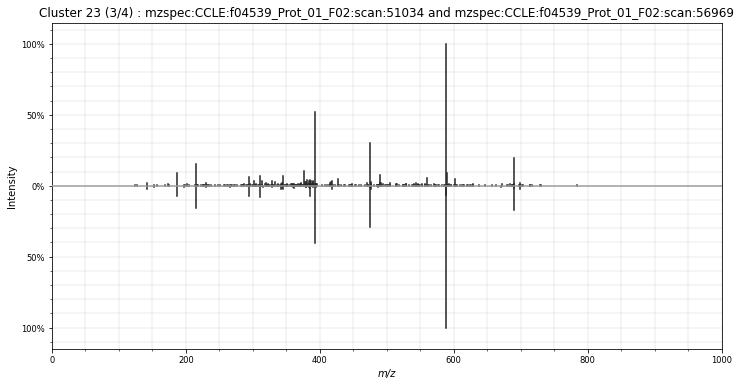

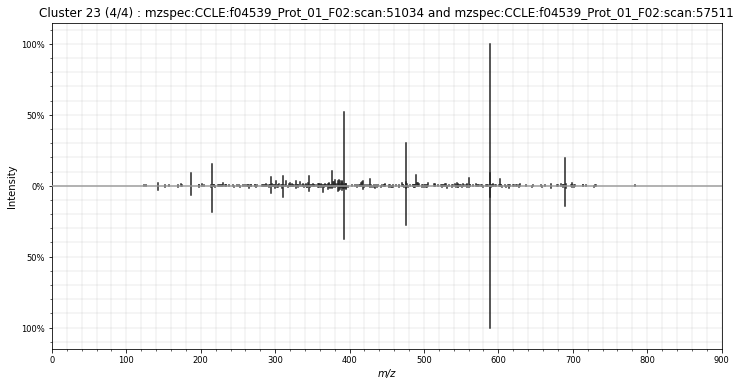

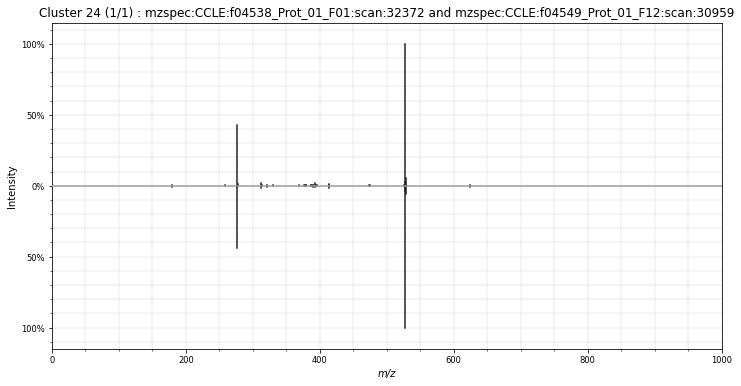

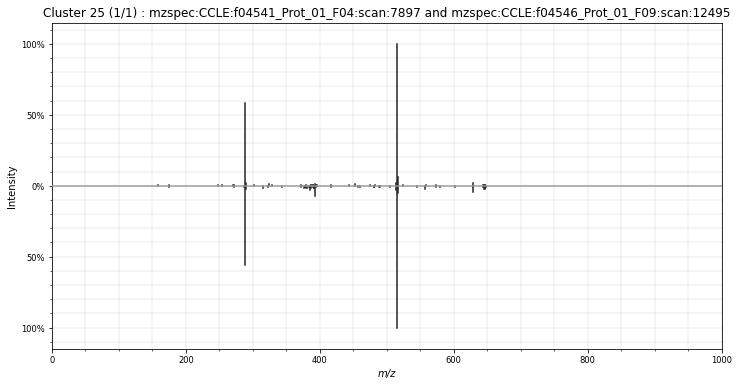

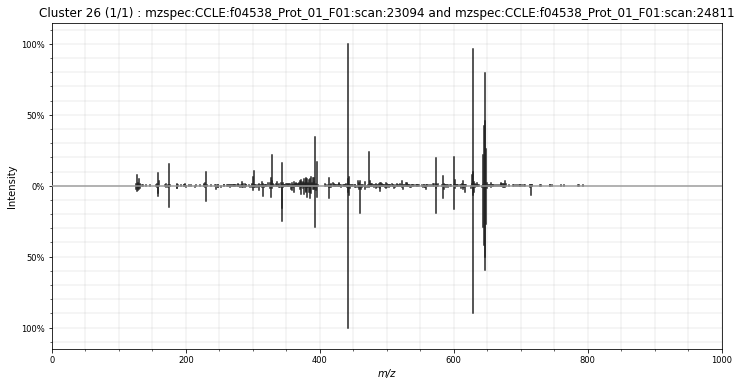

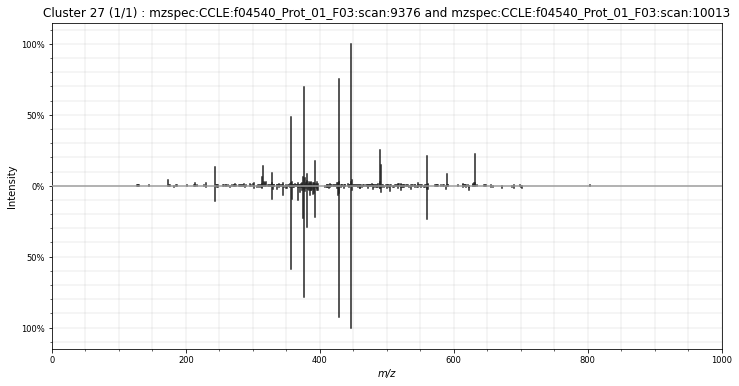

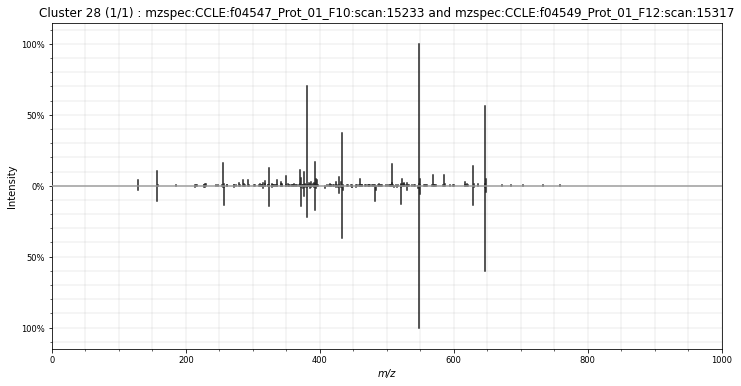

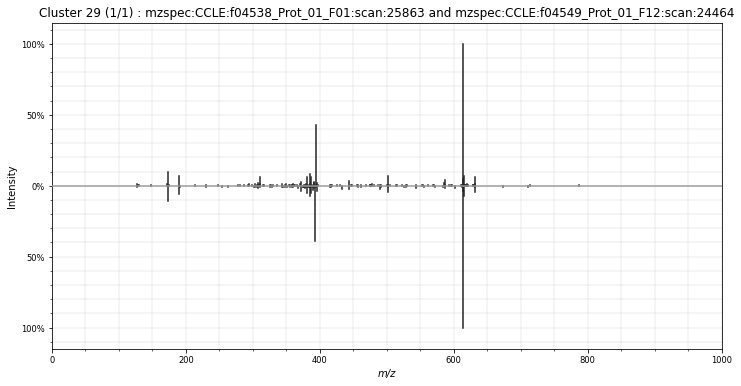

In [31]:
n_cl_plot = 30 # Number of clusters to plot

def extract_pkey(str):
    m = re.search('^.+:([0-9]+)+$', str)
    return int(m.group(1))



for i in range(0,n_cl_plot):
    currDf = clustDf[clustDf.cluster == i]
    identifiers = currDf.loc[:,"identifier"].tolist()
    precursor_charges = currDf.loc[:,"precursor_charge"].tolist()
    precursor_mzs = currDf.loc[:,"precursor_mz"].tolist()

    spf = ms_io.get_one_spectrum_from_pkl(dir_pkl, precursor_charges[0], precursor_mzs[0], identifiers[0])
    for j in range(1, len(identifiers)):
        fig, ax = plt.subplots(figsize=(12, 6))
        spectrum_top, spectrum_bottom = spf, ms_io.get_one_spectrum_from_pkl(dir_pkl,
                                                                            precursor_charges[j],
                                                                            precursor_mzs[j],
                                                                            identifiers[j])
        ax.set_title("Cluster {} ({}/{}) : {} and {}".format(i, j, len(identifiers)-1,
                     spectrum_top.identifier, spectrum_bottom.identifier))
        sup.mirror(spectrum_top, spectrum_bottom, ax=ax)
        plt.savefig(f"/home/maesk/tmp/{i}.png", dpi=300)
        plt.show()
        plt.close()